# Computer Vision

## Lab 6

### Imports

In [1]:
# IO
from glob import glob

# Computation
import cv2
import numpy as np
from scipy import spatial
from skimage import color, img_as_float32
from natsort import natsorted

# Plotting
import matplotlib.pyplot as plt

### Load images

In [2]:
path_pairs = list(zip(
    natsorted(glob('../assets/images-1024x768/*.png')),
    natsorted(glob('../assets/masks-1024x768/*.png')),
))

images = np.array([img_as_float32(cv2.cvtColor(cv2.imread(i_path), cv2.COLOR_BGR2RGB)) for i_path, _ in path_pairs])

masks = np.array([img_as_float32(cv2.cvtColor(cv2.imread(m_path), cv2.COLOR_BGR2RGB)) for _, m_path in path_pairs])
masks_gray = [color.rgb2gray(mask) for mask in masks]
masks_bin = [cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)[1] for mask in masks_gray]

num_images, height, width, channels = images.shape


### 1. Find Contours

#### 1.1. get_puzzle_contour

In [3]:
def get_puzzle_contour(mask):
    contours, _ = cv2.findContours(mask, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    max_contour = np.array([])
    max_contour_area = 0
    
    for contour in contours:
        area = cv2.contourArea(contour)
        
        is_closed = area > cv2.arcLength(contour, closed=True)
        has_max_area = area > max_contour_area
        
        if is_closed and has_max_area:
            max_contour = contour.reshape(-1, contour.shape[-1])
            max_contour_area = area
            
    return max_contour

#### 1.2. get_clockwise_contour

In [4]:
def get_clockwise_contour(contour):
    if (cv2.contourArea(contour, oriented=True) < 0):
        return np.flip(contour, axis=0)
    return contour

#### 1.3 Function explanations

*cv2.findContours* : Explanation

*cv2.contourArea with oriented=True* : Explanation

#### 1.4 Plotting contours

In [5]:
all_contours = [get_clockwise_contour(get_puzzle_contour(np.array(mask*255, dtype=np.uint8))) for mask in masks_bin]

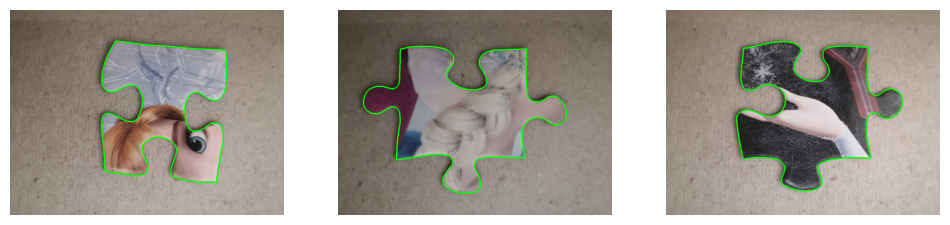

In [6]:
num_sample = 3
drawn_images = np.random.choice(len(masks), num_sample)

fig = plt.figure(figsize=(num_sample*4, 4))

for i, idx in enumerate(drawn_images):
    image = np.copy(images[idx])
    contour = all_contours[idx]
    contour_image = cv2.drawContours(image, [contour.reshape(-1, 1, 2)], 0, (0,1,0), 3)
    
    fig.add_subplot(1, num_sample, i+1)
    plt.imshow(contour_image)
    plt.axis('off')

### 2. Shape Models

#### 2.1. Extract Sides

##### 2.1.1 Load Corners from json file

In [7]:
import json
with open("../assets/corners.json", "r") as file:
    names, corner_ratios = json.load(file)
    
scaled_corners = corner_ratios * np.array([width, height])

##### 2.1.2 extract_sides

In [8]:
def extract_sides(contour, corners):
    corner_indices = spatial.KDTree(contour).query(corners)[1]
    corner_coords = contour[corner_indices]
    
    # Sort coordinates according to contour
    sorted_corner_indices = np.sort(corner_indices)
    sorted_corner_coords = np.zeros_like(corner_coords)
    for i, new_i in enumerate(np.argsort(corner_indices)):
        sorted_corner_coords[new_i] = corner_coords[i]
    
    # Roll first corner to be at 0
    contour = np.roll(contour, -sorted_corner_indices[0], axis=0)
    shifted_corner_indices = sorted_corner_indices - sorted_corner_indices[0]
    
    # Split contour to sides
    side_contours = np.split(contour, shifted_corner_indices)
    
    # Join first and last items
    if len(side_contours) == 5:
        last = side_contours[-1]
        side_contours = side_contours[:-1]
        side_contours[0] = np.concatenate((last, side_contours[0]))
    
    # Append corner to end (side starts and ends with corner)
    for i in range(len(side_contours)):
        side_contours[i] = np.append(side_contours[i], [side_contours[(i+1)%4][0]], axis=0)
    
    return side_contours


##### 2.1.3 Draw sides

In [9]:
side_contours = [extract_sides(all_contours[idx], scaled_corners[idx]) for idx in range(num_images)]

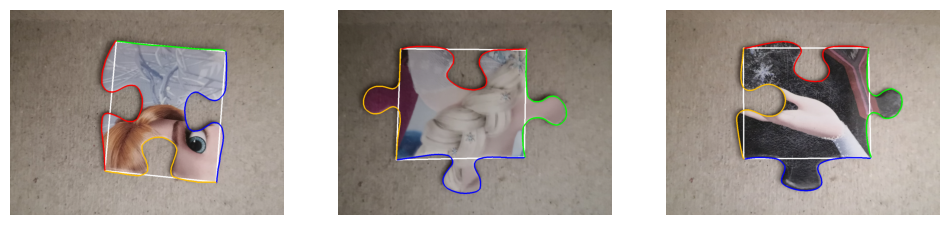

In [10]:
side_colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 0.75, 0)]

fig = plt.figure(figsize=(num_sample*4, 4))

for i, idx in enumerate(drawn_images):
    image = np.copy(images[idx])
    
    image_corners = scaled_corners[idx].astype(int)
    image = cv2.polylines(image, [image_corners], 1, (1,1,1), 3)
    
    for j, side in enumerate(side_contours[idx]):
        image = cv2.polylines(image, [side], 0, side_colors[j], 3)
    
    fig.add_subplot(1, num_sample, i+1)
    plt.imshow(image)
    plt.axis('off')

#### 2.2 Normalise Sides

##### 2.2.1 transform_puzzle_side

In [11]:
def transform_puzzle_side(contour):
    contour = np.array(contour, dtype=np.float32)
    
    # Shift to origin
    contour -= np.mean(contour[[0, -1]], axis=0)
    
    # Scale down to unit vectors
    scale_factor = np.linalg.norm([contour[-1] - contour[0]]) / 2
    contour /= scale_factor
    
    # Rotate
    end = contour[-1]
    theta = np.arctan2(end[1], end[0]) + np.pi # + np.pi to rotate 180deg (protruding top, sunken bottom)
    
    c = np.cos(-theta)
    s = np.sin(-theta)
    rotated = (np.array([[c, -s], [s, c]], dtype=np.float32) @ contour.T).T
    
    return rotated

In [12]:
transformed_sides = [[transform_puzzle_side(side) for side in image_sides] for image_sides in side_contours]

In [13]:
def draw_samples(samples):
    fig = plt.figure(figsize=(len(samples)*4, 4))

    for i, idx in enumerate(drawn_images):
        ax = fig.add_subplot(1, len(samples), i+1)
        
        for j, side in enumerate(samples[idx]):
            print(j, side[0], side[-1])
            ax.plot(side[:, 0], side[:, 1], color=side_colors[j])
            ax.plot(*side[0], color=side_colors[j], marker="o")
            ax.plot(*side[-1], color=side_colors[j], marker="o")

0 [1.0000000e+00 1.8892251e-08] [-1.0000000e+00 -1.8892251e-08]
1 [ 1.0000000e+00 -2.3093119e-09] [-1.0000000e+00  2.3093119e-09]
2 [9.9999994e-01 5.8512533e-09] [-9.9999994e-01 -5.8512533e-09]
3 [ 1.000000e+00 -9.533112e-08] [-1.000000e+00  9.533112e-08]
0 [1.000000e+00 7.035528e-11] [-1.000000e+00 -7.035528e-11]
1 [9.9999994e-01 7.5601303e-11] [-9.9999994e-01 -7.5601303e-11]
2 [1.000000e+00 3.903294e-08] [-1.000000e+00 -3.903294e-08]
3 [1.0000001e+00 4.5528250e-08] [-1.0000001e+00 -4.5528250e-08]
0 [1.0000000e+00 1.2246469e-16] [-1.0000000e+00 -1.2246469e-16]
1 [1.0000000e+00 2.3868775e-08] [-1.0000000e+00 -2.3868775e-08]
2 [ 1.0000000e+00 -1.1036476e-07] [-1.0000000e+00  1.1036476e-07]
3 [ 9.9999994e-01 -1.3555214e-08] [-9.9999994e-01  1.3555214e-08]


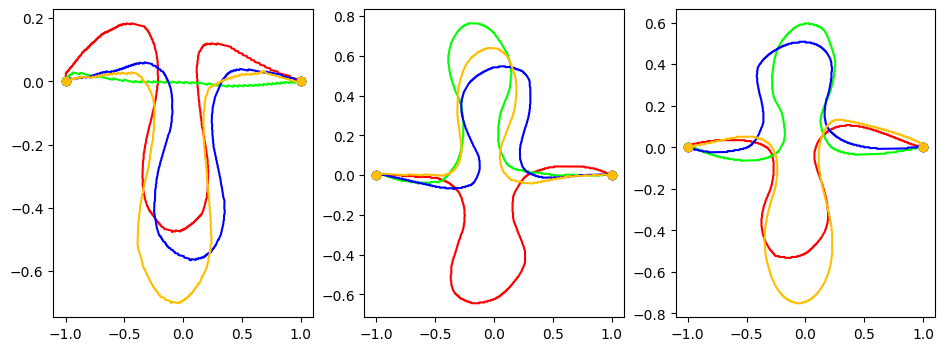

In [14]:
draw_samples(transformed_sides)

##### 2.2.2 even_spaced_contour

In [48]:
def even_spaced_contour(contour, num_points = 64):
    
    fig = plt.figure(figsize=(4*5, 4))
    
    # Calculate coordinates at which to evaluate [N=num_points]
    x = np.linspace(0, 1, num_points)
    
    # Calculate the length between segments [N=len(contour) - 1]
    xp = contour[1:] - contour[:-1]
    xp = np.hypot(xp[:, 0], xp[:, 1])
    
    # Cumulative sum of lengths divided by length of contour [N=len(contour) - 1]
    xp = np.cumsum(xp, axis=0) / cv2.arcLength(contour, closed=False)
    
    # Append 0 to start of array [N=len(contour)]
    xp = np.concatenate(([0], xp), axis=0)
    
    # Split the x and y values to interpolate separately [N=len(contour)]
    fp_0, fp_1 = np.hsplit(contour, 2)
    
    fig.add_subplot(141)
    plt.plot(xp, fp_0)
    plt.title("fp / xp (x)")
    plt.ylim((-1, 1))
    
    fig.add_subplot(142)
    plt.plot(xp, fp_1)
    plt.title("fp / xp (y)")
    plt.ylim((-1, 1))
    
    # Interpolate the x and y coordinates [N=num_points]
    y_0, y_1 = np.interp(x, xp, fp_0.flatten()), np.interp(x, xp, fp_1.flatten())
    
    # Stack interpolated values for x and y coordinates... shape=(num_points, 2)
    contour_new = np.stack((y_0, y_1), axis=1)
    
    fig.add_subplot(143)
    plt.plot(x, y_0)
    plt.ylim((-1, 1))
    plt.title("interpolated x")
    
    fig.add_subplot(144)
    plt.plot(x, y_1)
    plt.ylim((-1, 1))
    plt.title("interpolated y")
    
    
    assert len(contour_new) == num_points,\
        f"Output should be as long as the provided num_points\nnum_points={num_points}\noutput={len(contour_new)}"
    
    np.testing.assert_array_equal(contour[[0, -1]], contour_new[[0, -1]]),\
        f"The corners of the contour should remain unchanged\nOriginal: {contour[[0, -1]]}\nInterpolated=: {contour_new[[0, -1]]}"
        
    return contour_new

AssertionError: 
Arrays are not equal

Mismatched elements: 2 / 4 (50%)
Max absolute difference: 1.71099297e-07
Max relative difference: 1.00069111
 x: array([[ 1.000000e+00,  1.156947e-10],
       [-1.000000e+00, -1.156947e-10]], dtype=float32)
 y: array([[ 1.000000e+00,  1.156947e-10],
       [-9.999998e-01,  1.674052e-07]])

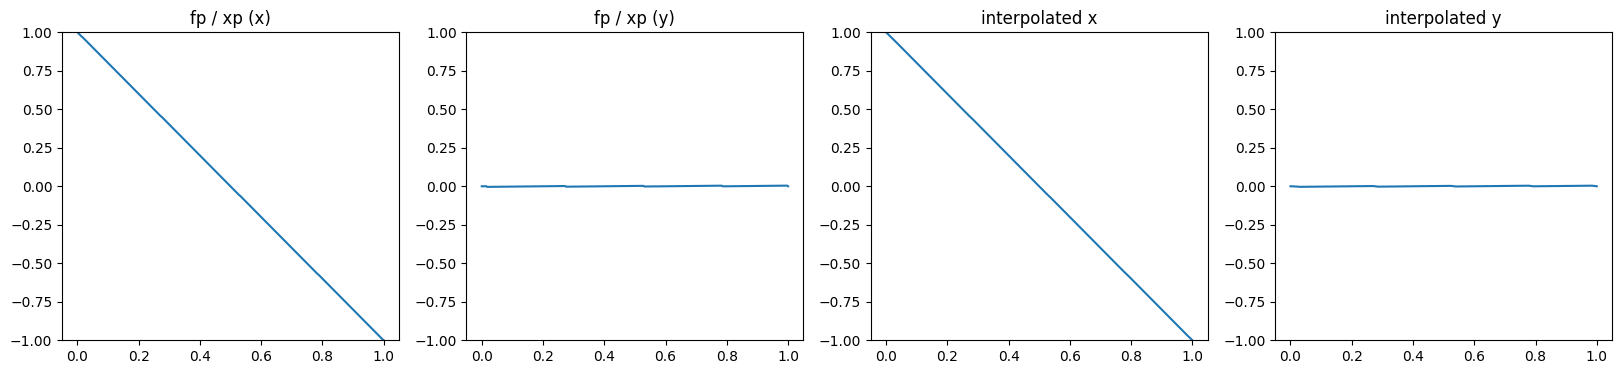

In [47]:
evenly_spaced_sides = np.array([[even_spaced_contour(side) for side in image_sides] for image_sides in transformed_sides[:1]], dtype=np.float32)

IndexError: index 24 is out of bounds for axis 0 with size 5

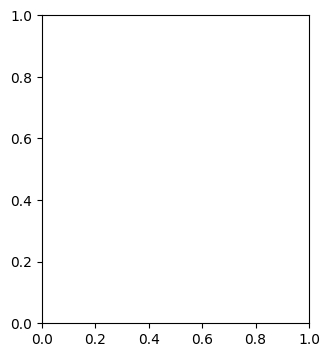

In [17]:
draw_samples(evenly_spaced_sides)

### 3. Match shape model

#### 3.1 is_flat_side

In [ ]:
def is_flat_side(contour, min_ratio=0.9):
    # Check distance between first and last point
    contour_distance = np.linalg.norm(contour[-1] - contour[0])
    
    # Check length of contour (Imagine distance but with stretched contour)
    contour_length = cv2.arcLength(contour.reshape(-1, 1, 2), closed=False)
    
    return contour_distance / contour_length >= min_ratio

#### 3.2 Non flat array

In [ ]:
non_flat_indices = np.nonzero([np.all([not is_flat_side(side) for side in image_sides]) for image_sides in evenly_spaced_sides])[0]
non_flat = evenly_spaced_sides[non_flat_indices]
non_flat_indices